In [1]:
import numpy as np
import os
import h5py
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy import signal

from PIL import Image
import pandas as pd

from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

from glob import glob

In [2]:
PATH = Path('../../data')
!ls {PATH}

feats.pkl
gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv
hdf5
images
images_unfilt
input_pipe.pkl
readme.txt
test.hdf5
train.hdf5
val.hdf5


# Train, Val, Test Splitting 

In [3]:
data = pd.read_csv(PATH/'gspy-db-20180813_O1_filtered_t1126400691-1205493119_snr7.5_tr_gspy.csv'); data.head()

,GPStime,peakFreq,snr,centralFreq,duration,bandwidth,id,ifo,label
0,1.134828e+09,32.246,40.137,1601.119,7.250,3183.373047,LYD73IJEbP,H1,Scattered_Light
1,1.134164e+09,29.897,38.256,2965.068,2.500,5894.235352,kQOi8X6807,H1,Scattered_Light
2,1.134478e+09,29.636,32.589,41.479,2.313,47.056068,wypbhS6TAa,H1,Scattered_Light
3,1.134478e+09,31.943,29.462,2532.243,3.000,5035.515137,aKFWKfLE8l,H1,Scattered_Light
4,1.137056e+09,32.552,28.537,1167.148,4.750,2324.383057,yWSM6mnbBM,H1,Scattered_Light


In [4]:
data['ifo'] = data['ifo'].map({l:i for i,l in enumerate(set(data.ifo))})
data['label'] = data['label'].map({l:i for i,l in enumerate(set(data.label))})
data.rename(index=str, columns={'label':'gen_target'}, inplace=True)

In [5]:
df, test_df = train_test_split(data, test_size=0.33, random_state=7)

In [6]:
val_sz = 0.2
train_df, val_df = train_test_split(df, test_size=val_sz, stratify=df.ifo, random_state=1111)

# Image proc 

In [7]:
SAMPLE_RATE = 4096.0
K1 = 100/70
NPERSEG = 128
NFFT = 512
WHITEN = True
FILTER = True

def whiten(strain:np.ndarray, fft:float=4, overlap:float=2) -> np.ndarray:
    return TimeSeries(strain).whiten(fft, overlap).value

In [8]:
def filter_strain(strain:np.ndarray, gps:float) -> np.ndarray:
    ts = TimeSeries(strain, t0=gps, sample_rate=SAMPLE_RATE)
    
    ts = ts.bandpass(50, 250, filtfilt=True)
    
    notches = [filter_design.notch(f, ts.sample_rate) for f in (60, 120, 180)]
    powernotch = filter_design.concatenate_zpks(*notches)
    ts = ts.filter(powernotch, filtfilt=True)
    
    if WHITEN: ts = ts.whiten(2, 1)
    return ts.value

In [9]:
def proc_strain(strain:np.ndarray, gps:float) -> np.ndarray:
    if FILTER: strain = filter_strain(strain, gps)
    #if WHITEN: strain = whiten(strain)
    _, _, img = signal.spectrogram(strain, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
    img = np.log(np.sqrt(img))
    img = preprocessing.minmax_scale(img)
    img = np.round(255*img).astype(np.uint8)
    img = np.broadcast_to(img[:,:,None],(img.shape[0], img.shape[1],3))
    return img

In [10]:
def create_image(gid:str, label:str, mode:str, gps:float) -> None:
    name = glob(str(PATH/f'hdf5/*{gid}*'))[0]
    with h5py.File(PATH/f'hdf5/{name}', 'r') as fin: strain = np.array(fin["Strain"]["Strain"].value)
    if np.isnan(np.sum(strain)): return
    img = proc_strain(strain, gps)
    Image.fromarray(img, 'RGB').save(PATH/f'images/{mode}/{label}/{gid}.png')

In [11]:
for mode in ['train', 'val', 'test']:
    for l in set(data.gen_target): os.makedirs(PATH/'images'/mode/str(l), exist_ok=True)

In [12]:
def proc_sample(df:pd.DataFrame, mode:str) -> None:
    with ThreadPoolExecutor(8) as e: e.map(create_image, df.id.values, df.gen_target, [mode for _ in range(len(df))], df.GPStime)

In [13]:
%%capture --no-stdout
for i in range(100): create_image(df.id.values[i:i+1][0], df.gen_target.values[i:i+1][0], 'val', df.GPStime.values[i:i+1][0])

In [14]:
len(train_df)

3572

In [15]:
len(val_df)

894

In [16]:
len(test_df)

2201

In [22]:
%%capture --no-stdout
proc_sample(train_df, 'train')

In [20]:
%%capture --no-stdout
proc_sample(val_df, 'val')

In [17]:
%%capture --no-stdout
proc_sample(test_df, 'test')

# Testing 

In [39]:
gid = 'bdjBbWwqDG'
gps = data.loc[data.id==gid, 'GPStime'].values[0]
name = glob(str(PATH/f'hdf5/*{gid}*'))[0]
with h5py.File(PATH/f'hdf5/{name}', 'r') as fin: strain = np.array(fin["Strain"]["Strain"].value)

In [40]:
img = proc_strain(strain, gps)

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


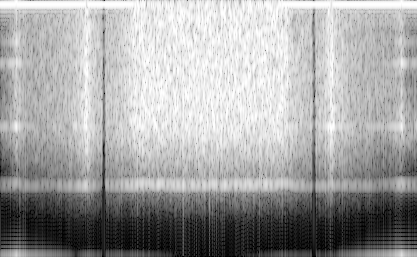

In [38]:
Image.fromarray(img, 'RGB')

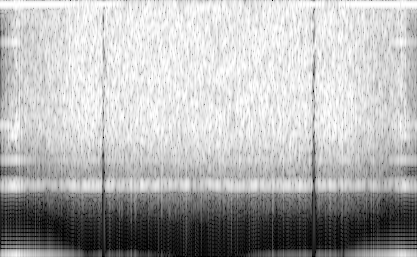

In [41]:
Image.fromarray(img, 'RGB')

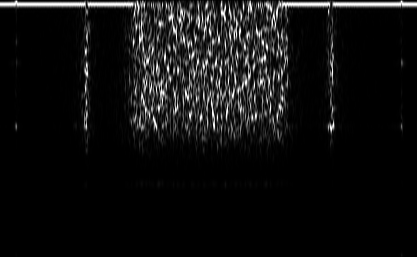

In [27]:
Image.fromarray(img, 'RGB')

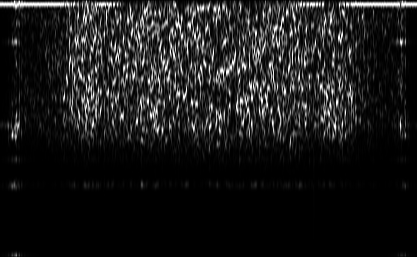

In [34]:
Image.fromarray(img, 'RGB')

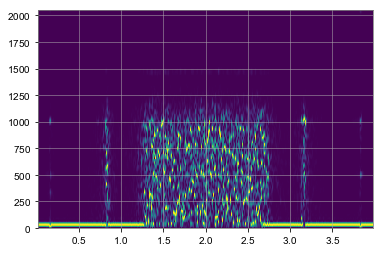

In [28]:
f, t, img = signal.spectrogram(pstrain, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, preprocessing.minmax_scale(img))

Text(0, 0.5, 'Strain')

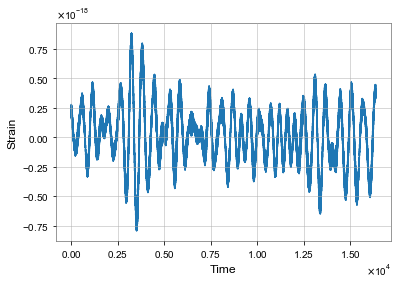

In [143]:
plt.plot(np.arange(len(strain)), strain)
plt.xlabel("Time")
plt.ylabel("Strain")

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


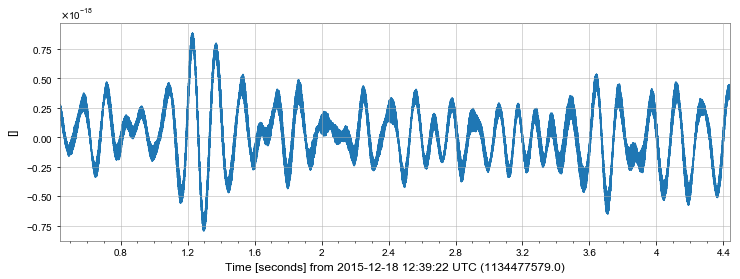

In [144]:
hdata = TimeSeries(strain, t0=gps,
                   sample_rate=SAMPLE_RATE)
plot = hdata.plot()
plot.show()

/Users/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


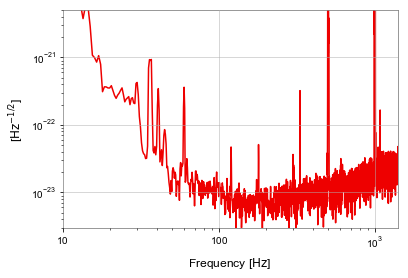

In [145]:
hasd = hdata.asd(fftlength=2)
plot2 = hasd.plot(color='gwpy:ligo-hanford')
ax = plot2.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(3e-24, 5e-21)
plot2.show()

/Users/giles/anaconda3/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


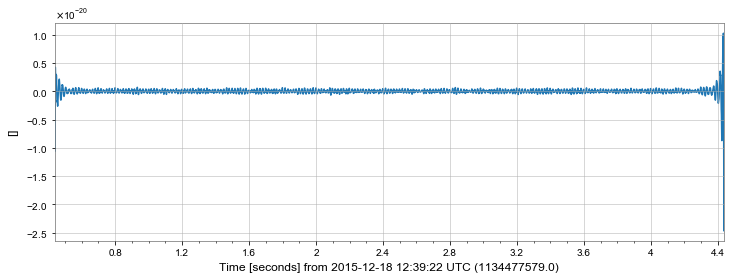

In [146]:
hbp = hdata.bandpass(50, 250, filtfilt=True)
plot = hbp.plot()

In [147]:
gps

1134477579.438

/Users/giles/anaconda3/lib/python3.6/site-packages/gwpy/types/series.py:912: UserWarning: TimeSeries.crop given start smaller than current start, crop will begin when the Series actually starts.
  % type(self).__name__)


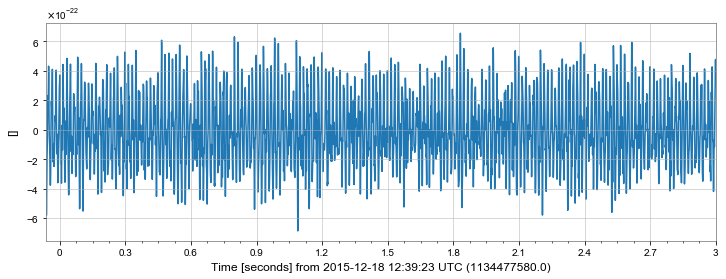

In [86]:
hbp = hbp.crop(int(gps+0.5), int(gps+3.8))
plot = hbp.plot()

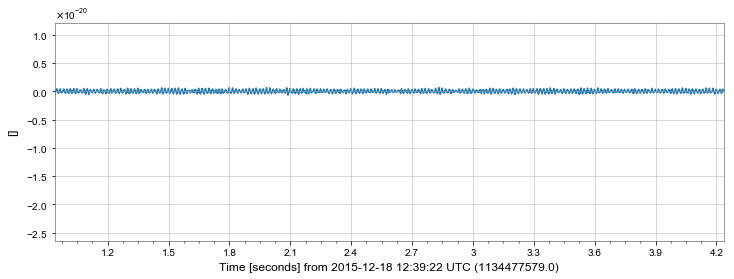

In [148]:
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps+0.5, gps+3.8)
plot

In [149]:
notches = [filter_design.notch(f, hdata.sample_rate) for f in (60, 120, 180)]
powernotch = filter_design.concatenate_zpks(*notches)
hclean = hbp.filter(powernotch, filtfilt=True)

(1134477579.938, 1134477583.238)

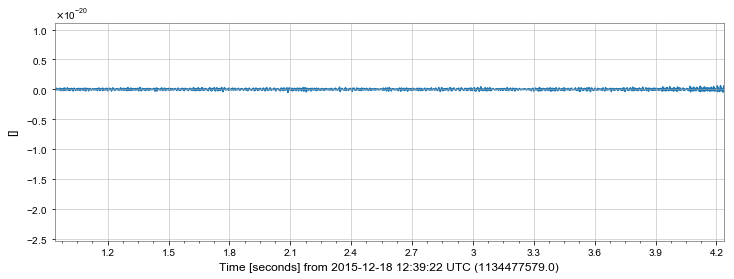

In [154]:
plot = hclean.plot()
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps+0.5, gps+3.8)

In [155]:
whitened = hclean.whiten(2, 1)

(1134477579.938, 1134477583.238)

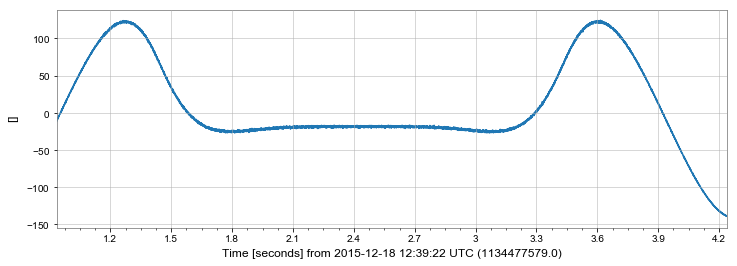

In [156]:
plot = whitened.plot()
ax = plot.gca()
ax.set_epoch(int(gps))
ax.set_xlim(gps+0.5, gps+3.8)

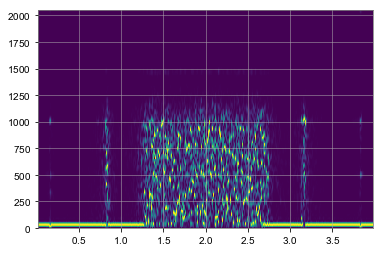

In [157]:
f, t, img = signal.spectrogram(whitened.value, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, preprocessing.minmax_scale(img))

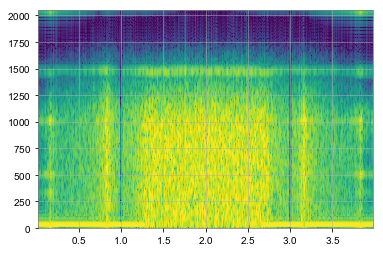

In [158]:
f, t, img = signal.spectrogram(whitened.value, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, preprocessing.minmax_scale(np.log(np.sqrt(img))))

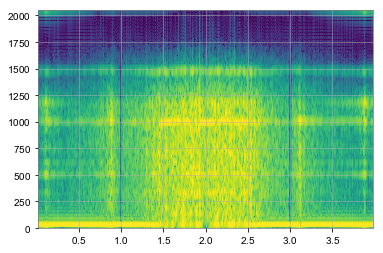

In [169]:
f, t, img = signal.spectrogram(hclean.whiten(4,2).value, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, preprocessing.minmax_scale(np.log(np.sqrt(img))))

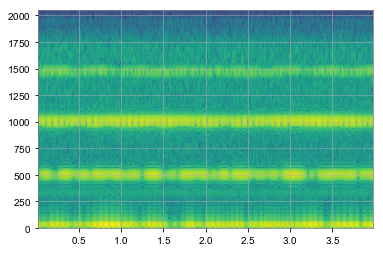

In [160]:
f, t, img = signal.spectrogram(strain, window='hann',fs=SAMPLE_RATE, nperseg=NPERSEG, noverlap=NPERSEG//K1, nfft=NFFT)
plt.figure()
plt.pcolormesh(t, f, np.log(np.sqrt(img)))

In [111]:
img = proc_strain(hclean.value, 2, 1)

In [113]:
img.shape

(257, 319, 3)

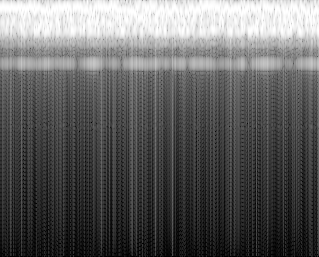

In [114]:
Image.fromarray(img, 'RGB')